In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "3"
device = 'cuda'
from time import time

import losses

In [4]:
filename_out    = 'output/ff_nn.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 1.0e-4
#Batch size
batch_size      = 256
# Total number of epochs to train for
n_epochs        = 50

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_x_features     = 7

ndim_y     = 512

# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None


############
#  Losses  #
############

train_forward_mmd    = True

lambd_mmd_for_class    = 500.
lambd_mmd_for_feature  = 50.

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 5e-2 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 4

mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 10
#
exponent_clamping = 3.0
#
hidden_layer_sizes = 1024
#
use_permutation = True
#
verbose_construction = False

In [5]:
def read_data(path):
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    labels = torch.zeros(len(files), 512, dtype = torch.float32)
    inputs = torch.zeros(len(files), 10, dtype = torch.float32)
    input_keys = ['shape', 'radius', 'radius_pd','length', 'length_pd',  'volfraction']
    for i,f in enumerate(files):
        with  h5py.File(os.path.join(path,f),'r') as file:
            print(file, end = '\r')
            labels[i,:] = torch.from_numpy(file['entry/I'][()].flatten())#I_noisy
            for i_k, key in enumerate(input_keys):
                try:
                    if key == 'shape':
                        shape = file['properties'][key][()].decode("utf-8")
                        if shape == 'sphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([1,0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k:i_k+3] = torch.tensor([0,1,0])
                        else:
                            inputs[i, i_k:i_k+3] = torch.tensor([0,0,1])
                    elif key =='radius':
                        if shape == 'sphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([file['properties'][key][()],0,0]) 
                        elif shape == 'hardsphere':
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,file['properties'][key][()],0])
                        else:
                            inputs[i, i_k+2:i_k+5] = torch.tensor([0,0,file['properties'][key][()]])
                    else:
                        inputs[i, i_k+4] = file['properties'][key][()]
                except KeyError:
                    # spheres don't have all of the properties a cylinder does
                    pass
    return inputs, labels
            

In [6]:
inputs,labels = read_data('/home/slaskina/simulations')

In [7]:

# Creating data indices for training and validation splits:
dataset_size = len(labels)
indices = list(range(dataset_size))
test_size = 0.1
val_size = 0.2
test_split = int(np.floor(test_size * dataset_size))
val_split = int(np.floor(val_size * dataset_size))
np.random.seed(1234)
np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:dataset_size-test_split-val_split], indices[dataset_size-test_split-val_split:dataset_size-test_split], indices[dataset_size-test_split:]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
batch_size=128

In [8]:
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset( labels, inputs), batch_size=batch_size, drop_last=True, sampler = val_sampler)

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(labels, inputs), batch_size=batch_size, drop_last=True, sampler = train_sampler)

In [9]:
class ForwardScatteringLinear(nn.Module):
    def __init__(self, in_dim, out_dim,N_blocks, hidden_layers) -> None:
        super().__init__()
        self.linear_in = nn.Linear(in_dim, hidden_layers)
        self.linear_middle = nn.Linear(hidden_layers,hidden_layers)
        self.linear_out = nn.Linear(hidden_layers,out_dim)
        self.N_blocks = N_blocks
    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for _ in range(self.N_blocks):
            x = F.relu(self.linear_middle(x))
        x = self.linear_out(x)
        return x

In [72]:
class ForwardScatteringConvolutional(nn.Module):
    def __init__(self, N_blocks) -> None:
        super().__init__()
        self.N_blocks = N_blocks
        self.sequence_block = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size = 5,padding = 2, stride=1),
            nn.ELU(),
            nn.AvgPool1d(5, padding=2, stride=1),
        )
        self.s1 = nn.Sequential(
            nn.Conv1d(in_channels = 512, out_channels = 128 , kernel_size = 11, padding=5, stride=3),
            nn.ELU()
        )
        self.linear_out = nn.Sequential(    
            nn.Linear(128, 10),
            nn.ELU()
        )
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = x.reshape(len(x), -1, 1)
        for _ in range(self.N_blocks):
            x =  self.sequence_block(x)
        x = self.s1(x)
        x = self.flatten(x)
        x = self.linear_out(x)
        return x.reshape(-1,10)

In [73]:
model_simple_conv = ForwardScatteringConvolutional(5).to(device)
print(model_simple_conv)

ForwardScatteringConvolutional(
  (sequence_block): Sequential(
    (0): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ELU(alpha=1.0)
    (2): AvgPool1d(kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (s1): Sequential(
    (0): Conv1d(512, 128, kernel_size=(11,), stride=(3,), padding=(5,))
    (1): ELU(alpha=1.0)
  )
  (linear_out): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


In [25]:
model_simple_linear = ForwardScatteringLinear(ndim_y,ndim_x_class+ndim_x_features,N_blocks, hidden_layer_sizes).to(device)
print(model_simple_linear)

ForwardScatteringLinear(
  (linear_in): Linear(in_features=512, out_features=1024, bias=True)
  (linear_middle): Linear(in_features=1024, out_features=1024, bias=True)
  (linear_out): Linear(in_features=1024, out_features=10, bias=True)
)


In [11]:
def params_trainable(model):
    params_trainable = list(filter(lambda p: p.requires_grad, model.parameters()))
    for p in params_trainable:
        p.data = init_scale * torch.randn(p.data.shape).to(device)
    return params_trainable

def optimizer(model):
    optim = torch.optim.Adam(params_trainable(model), lr=lr_init, betas=adam_betas, eps=1e-6, weight_decay=l2_weight_reg)
    return optim 

gamma = (final_decay)**(1./n_epochs)

def optim_step(optim):
    #for p in params_trainable:
        #print(torch.mean(torch.abs(p.grad.data)).item())
    optim.step()
    optim.zero_grad()

def save(name, model, optim):
    torch.save({'opt':optim.state_dict(),
                'net':model.state_dict()}, name)

def load(name, model, optim):
    state_dicts = torch.load(name)
    model.load_state_dict(state_dicts['net'])
    try:
        optim.load_state_dict(state_dicts['opt'])
    except ValueError:
        print('Cannot load optimizer for some reason or other')

In [78]:

def noise_batch(ndim):
    return torch.randn(batch_size, ndim).to(device)


def loss_forward_mmd(x_class, x_features, pred):
    pred_class, pred_features = pred[:,:3], pred[:, 3:]
    MMD_class = losses.backward_mmd(x_class, pred_class) 
    MMD_features = losses.backward_mmd(x_features, pred_features)
    if mmd_back_weighted:
        MMD_class *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
        MMD_features *= torch.exp(- 0.5 / y_uncertainty_sigma**2 * losses.l2_dist_matrix(pred, pred))
    return lambd_mmd_for_class * torch.mean(MMD_class)+lambd_mmd_for_feature * torch.mean(MMD_features)

def train_epoch(model, optim, i_epoch, loader,  test=False):
    if not test:
        model.train()
        loader = train_loader

    if test:
        model.eval()
        loader = test_loader
        nograd = torch.no_grad()
        nograd.__enter__()


    batch_idx = 0
    loss_history = []

    for y,x in loader: # because y is  actualy the result of x
        print(y.shape, x.shape)

        if batch_idx > n_its_per_epoch:
            break

        batch_idx += 1

        x, y = x.to(device), y.to(device)
        x_class, x_features = x[:, :3],x[:, 3:]


        if add_y_noise > 0:
            y += add_y_noise * noise_batch(ndim_y)
     
        pred = model(y).reshape(-1,10)
        loss = loss_forward_mmd(x_class, x_features, pred)
        loss_history.append([loss.item()]) # lisr of lists: list for each batch
        
        if not test:
            loss.backward()
            optim_step(optim)

    if test:
        nograd.__exit__(None, None, None)
    return np.mean(loss_history, axis=0)

def train(model, optim, train_loader, test_loader):

    try:
        t_start = time()
        for i_epoch in range(-pre_low_lr, n_epochs):

            if i_epoch < 0:
                for param_group in optim.param_groups:
                    param_group['lr'] = lr_init * 1e-1

            train_losses = train_epoch(model, optim, i_epoch, train_loader) # mean over batches
            test_losses  = train_epoch(model, optim, i_epoch, test_loader, test=True)
            t = np.concatenate([train_losses, test_losses])
            print('Epoch {i_e}: training loss: {tl}, test loss: {testl}'.format(i_e = i_epoch, tl = t[0], testl = t[1]))


    except:
        save(filename_out + '_ABORT',model, optim)
        raise

    finally:
        print("\n\nTraining took %f minutes\n\n" % ((time()-t_start)/60.))
        save(filename_out,model, optim)


In [79]:
train(model_simple_linear, optimizer(model_simple_linear), train_loader, test_loader)

torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size([128, 512]) torch.Size([128, 10])
torch.Size

KeyboardInterrupt: 

In [14]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
import pandas as pd

In [15]:
def create_table_from_outcome(pred, sampled_inputs):
    df = pd.DataFrame(columns = ['true_shape', 'pred_shape', 'radius','pred_radius'], index = [])
    df['true_shape'] = sampled_inputs[:,:3].argmax(axis=1)
    df['pred_shape'] = pred[:,:3].argmax(axis=1)
    df['radius'] = np.take_along_axis(sampled_inputs[:,3:6],df.true_shape.values.reshape(-1,1), axis=1)
    df['pred_radius'] = np.take_along_axis(pred[:,3:6],df.pred_shape.values.reshape(-1,1), axis=1)
    df['radius_pd'] = sampled_inputs[:,6]
    df['pred_radius_pd'] = pred[:,6]
    df['length'] = sampled_inputs[:,7]
    df['pred_length'] = np.where(df.pred_shape.values ==2, pred[:,7], 0) # only those identified as cylinder should have lengh and pd_length
    df['length_pd'] = sampled_inputs[:,8]
    df['pred_length_pd'] = np.where(df.pred_shape.values ==2, pred[:,8], 0)
    df['volfraction'] = sampled_inputs[:,9]
    df['pred_volfraction'] = np.where(df.pred_shape.values ==1, pred[:,9], 0)
    return df

In [16]:
def make_prediction(labels, model):
    return model(labels)


In [18]:
predicted_features = make_prediction(labels[test_indices], model_simple_linear.to('cpu')).detach().numpy()

In [20]:
df = create_table_from_outcome(predicted_features, inputs[test_indices])

In [21]:
def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

In [22]:
def outcomes(df, data_name):
    print('Accuracy is {0:.2%}'.format((df.true_shape == df.pred_shape).sum()/len(df)))
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    shapes = ['sphere', 'hardsphere', 'cylinder']
    # shape classified correctly
    correct = [((df.true_shape == 0) & (df.pred_shape == 0)).sum(),((df.true_shape == 1) & (df.pred_shape == 1)).sum(),((df.true_shape == 2) & (df.pred_shape == 2)).sum()]
    wrong = [((df.true_shape == 0) & (df.pred_shape != 0)).sum(),((df.true_shape == 1) & (df.pred_shape != 1)).sum(),((df.true_shape == 2) & (df.pred_shape != 2)).sum()]
    correct = [correct[i]/(correct[i]+ wrong[i])*100 for i in range(len(correct))]
    wrong = [100-correct[i] for i in range(len(wrong))]
    ax = axes[0,0]
    ax.bar(shapes, correct, width=0.35, label='correct', color = 'peachpuff')
    ax.bar(shapes, wrong, width=0.35,bottom=correct, label='misclassified', color = 'plum')
    ax.set_ylabel('correct predictions, %')
    ax.set_title('Shapes predictions')
    ax.text(-0.05, 5, 'correct', rotation = 90)
    ax.text(0.95, 5, 'correct', rotation = 90)
    ax.text(1.95, 5, 'correct', rotation = 90)
    
    ax.text(-0.05, 65, 'misclassified', rotation = 90)
    ax.text(0.95, 65, 'misclassified', rotation = 90)
    ax.text(1.95, 65, 'misclassified', rotation = 90)

    # radius of a correctly identified shapes
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
      
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

    print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
    print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
    print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
        (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))
    #stacked df to create violinplots
    df_stacked = df[df.true_shape ==df.pred_shape].drop(columns = ['pred_shape']).set_index('true_shape').stack().reset_index().rename(columns = {'level_1':'feature', 0:'value'})
    df_stacked.loc[df_stacked.true_shape == 0, 'true_shape'] = "sphere"
    df_stacked.loc[df_stacked.true_shape == 1, 'true_shape'] = "hardsphere"
    df_stacked.loc[df_stacked.true_shape == 2, 'true_shape'] = "cylinder"

    ax = axes[0,1]
    data = df_stacked[(df_stacked.feature == 'radius')|(df_stacked.feature == 'pred_radius')]
    data.loc[data.feature == 'radius', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius distribution for correct shapes')
    ax.set_ylabel("radius, nm")
    ax.set_xlabel("")
    ax.legend()

    ax = axes[0,2]
    data = df_stacked[(df_stacked.feature == 'radius_pd')|(df_stacked.feature == 'pred_radius_pd')]
    data.loc[data.feature == 'radius_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius polidispersity distribution\nfor correct shapes')
    ax.legend()
    ax.set_ylabel("radius pd")
    ax.set_xlabel("")

    # length
    df_stacked = df.set_index(['true_shape', 'pred_shape']).stack().reset_index().rename(columns = {'level_2':'feature', 0:'value'}).assign(y=1)

    ax = axes[1,0]
    data = df_stacked[((df_stacked.feature == 'length')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature",split = True, ax=ax, palette=['peachpuff', 'plum'] )
    ax.set_title('Length distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length, nm")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 4.2, "sampled")
    ax.text(0.2, 4.2, "predicted")
    ax.set_ylim([-.5,6])

    ax = axes[1,1]
    data = df_stacked[((df_stacked.feature == 'length_pd')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length_pd')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False),  x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Length polidispersity distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length pd")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.25, "sampled")
    ax.text(0.2, 0.25, "predicted")
    ax.set_ylim([-0.05, 0.35])

    ax = axes[1,2]
    data = df_stacked[((df_stacked.feature == 'volfraction')&(df_stacked.true_shape ==1))|((df_stacked.feature == 'pred_volfraction')&(df_stacked.pred_shape == 1))]
    data.loc[data.feature == 'volfraction', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_volfraction', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature", split = True, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Volume fraction distribution of hardsphere')
    ax.set_xlabel("hardsphere")
    ax.set_ylabel("volumefraction")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.5, "sampled")
    ax.text(0.2, 0.5, "predicted")
    ax.set_ylim([-0.1, 0.7])

    plt.suptitle('{d} Data'.format(d = data_name))

In [23]:
df

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,2,2,0.127441,0.274987,0.041223,0.381534,0.332047,-0.368094,0.068415,0.478472,0.0,0.0
1,2,2,0.043445,0.274976,0.065933,0.381541,2.211643,-0.368113,0.073377,0.478460,0.0,0.0
2,2,2,0.032580,0.274977,0.007176,0.381540,2.162128,-0.368113,0.101232,0.478463,0.0,0.0
3,1,2,0.269041,0.274973,0.039296,0.381543,0.000000,-0.368108,0.000000,0.478459,0.1,0.0
4,0,2,0.086074,0.274977,0.002811,0.381543,0.000000,-0.368105,0.000000,0.478460,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,2,0.424327,0.274984,0.051840,0.381549,0.000000,-0.368105,0.000000,0.478473,0.3,0.0
1496,0,2,0.119943,0.274979,0.059004,0.381538,0.000000,-0.368097,0.000000,0.478465,0.0,0.0
1497,2,2,0.345031,0.275047,0.034487,0.381511,0.348878,-0.368140,0.016987,0.478549,0.0,0.0
1498,0,2,0.269215,0.275016,0.021152,0.381521,0.000000,-0.368105,0.000000,0.478529,0.0,0.0


Accuracy is 34.53%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 0.0133
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 0.1089
MSE for cylinder length for correctly identified instances: 3.4822
MSE for cylinder length polydispersity for correctly identified instances: 0.1564
MSE for cylinder length for correctly identified instances: inf


ValueError: There must be exactly two hue levels to use `split`.'

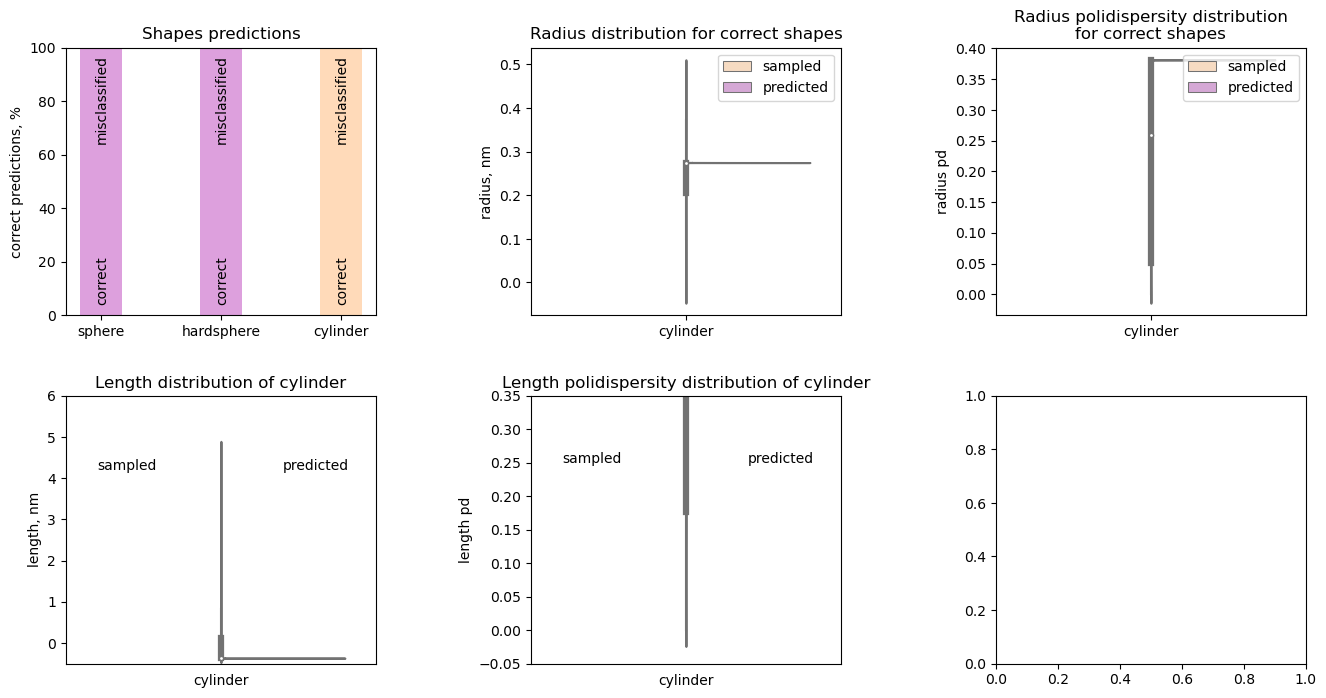

In [24]:
outcomes(df, 'test')

In [74]:
train(model_simple_conv, optimizer(model_simple_conv), train_loader, test_loader)

Epoch 0: training loss: 2431.9873195741234, test loss: 1654.9146622367527
Epoch 1: training loss: 1633.3177907059833, test loss: 1619.636379076087
Epoch 2: training loss: 1631.3334320812692, test loss: 1622.74633258322
Epoch 3: training loss: 1613.2707668397484, test loss: 1534.5182733950408
Epoch 4: training loss: 1098.7750296243807, test loss: 639.8052500849185
Epoch 5: training loss: 469.16351095060026, test loss: 340.8869283924932
Epoch 6: training loss: 265.0750920365496, test loss: 203.730817048446
Epoch 7: training loss: 171.18416111643722, test loss: 148.54522240680197
Epoch 8: training loss: 128.36578331924068, test loss: 116.61169400422469
Epoch 9: training loss: 105.33489673893627, test loss: 97.75845370085344
Epoch 10: training loss: 91.51423040250452, test loss: 84.78945557967477
Epoch 11: training loss: 81.65073515729206, test loss: 77.79673402205758
Epoch 12: training loss: 74.68789691459841, test loss: 72.2006019923998
Epoch 13: training loss: 69.11187232412944, test lo

Accuracy is 34.53%
MSE for radius per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 1.4612
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: inf, hardsphere: inf and cylinder: 1.1088
MSE for cylinder length for correctly identified instances: 5.9899
MSE for cylinder length polydispersity for correctly identified instances: 21427.1855
MSE for cylinder length for correctly identified instances: inf


ValueError: There must be exactly two hue levels to use `split`.'

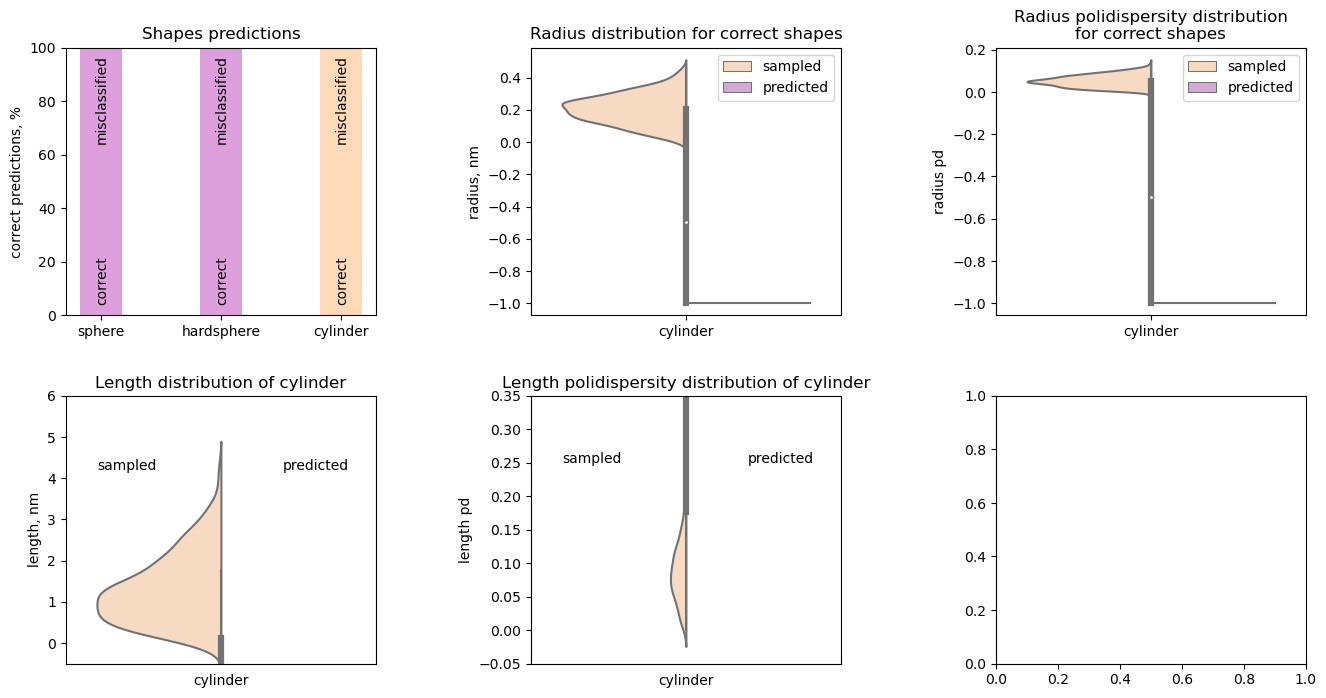

In [76]:
predicted_features = make_prediction(labels[test_indices], model_simple_conv.to('cpu')).detach().numpy()
df = create_table_from_outcome(predicted_features, inputs[test_indices])
outcomes(df, 'test')

In [35]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)#
        # Compute prediction and loss
        pred = model(X).reshape(-1,10)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch ==size:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]",end = '')


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X).reshape(-1,10)
            test_loss += loss_fn(pred, y).item()
            #correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    #correct /= size
    print(f"Avg loss: {test_loss:>8f} \n",end = '')